In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import torch
import yaml
from copy import deepcopy
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import BayesianExplorationGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

vocs = deepcopy(tnk_vocs)

# can only explore one objective
del vocs.objectives["y2"]

vocs

VOCS(variables={'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]}, constraints={'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]}, objectives={'y1': 'MINIMIZE'}, constants={'a': 'dummy_constant'}, linked_variables={})

In [2]:
from xopt.generators.bayesian.expected_improvement import ExpectedImprovementGenerator
from xopt.generators.bayesian.options import ModelOptions
from xopt.generators.bayesian.expected_improvement import BayesianOptions
from gpytorch.means import ConstantMean

constraint_mean1 = ConstantMean()
constraint_mean1.initialize(constant=-5.)
constraint_mean1.constant.requires_grad = False

constraint_mean2 = ConstantMean()
constraint_mean2.initialize(constant=5.)
constraint_mean2.constant.requires_grad = False

model_options = ModelOptions(mean_modules={"c1":constraint_mean1, "c2":constraint_mean2})
generator_options = BayesianOptions(model=model_options)
generator = ExpectedImprovementGenerator(vocs, options=generator_options)

evaluator = Evaluator(function=evaluate_TNK)
# generator = BayesianExplorationGenerator(vocs, generator_options)

In [3]:
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.evaluate_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.7, 0.95]}))

,x1,x2,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error
1,1.00,0.70,1.00,0.70,0.584045,0.290,"[1, 2, 3]",0.000161,False
2,0.75,0.95,0.75,0.95,0.494833,0.265,"[1, 2, 3]",0.000017,False


In [4]:
for i in range(10):
    print(f"step {i}")
    X.step()

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9


In [5]:
X.data

,x1,x2,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error,a
1,1.000000,0.700000,1.000000,0.700000,0.584045,0.290000,"[1, 2, 3]",0.000161,False,NaN
2,0.750000,0.950000,0.750000,0.950000,0.494833,0.265000,"[1, 2, 3]",0.000017,False,NaN
3,0.831937,0.674854,0.831937,0.674854,0.156654,0.140756,"[1, 2, 3]",0.000023,False,dummy_constant
4,1.057349,0.633958,1.057349,0.633958,0.590763,0.328583,"[1, 2, 3]",0.000023,False,dummy_constant
5,0.700953,0.855855,0.700953,0.855855,0.225421,0.167015,"[1, 2, 3]",0.000024,False,dummy_constant
6,0.706859,0.841618,0.706859,0.841618,0.189884,0.159494,"[1, 2, 3]",0.000022,False,dummy_constant
7,1.034130,0.352267,1.034130,0.352267,0.142049,0.307119,"[1, 2, 3]",0.000024,False,dummy_constant
8,1.024641,0.526363,1.024641,0.526363,0.301126,0.275944,"[1, 2, 3]",0.000022,False,dummy_constant
9,0.598029,0.836827,0.598029,0.836827,0.145534,0.123062,"[1, 2, 3]",0.000022,False,dummy_constant
10,0.098077,0.807716,0.098077,0.807716,-0.302511,0.256231,"[1, 2, 3]",0.000023,False,dummy_constant


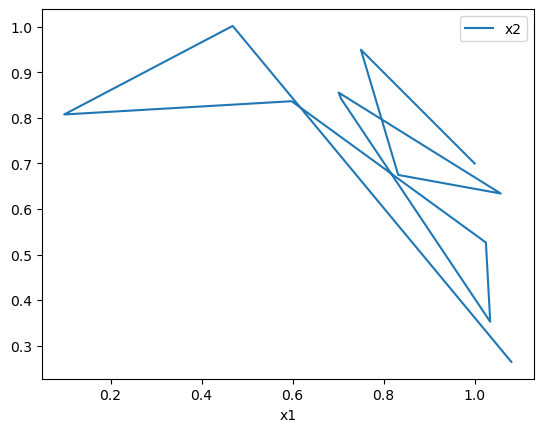

In [6]:
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

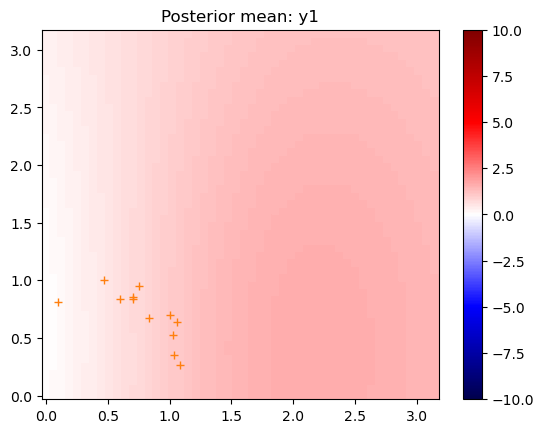

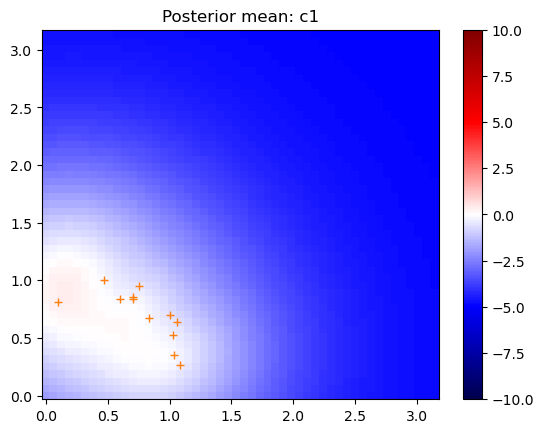

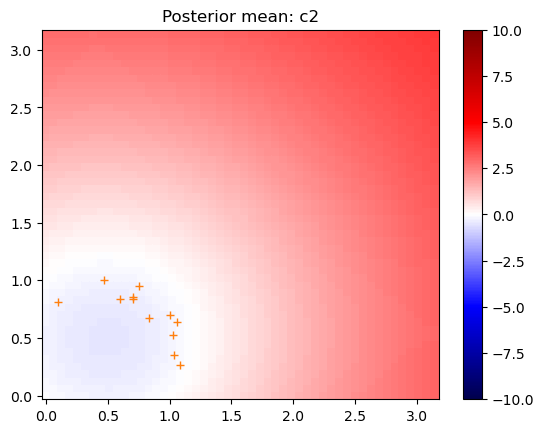

In [7]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = generator.vocs.bounds
model = generator.train_model(generator.data)

# create mesh
n = 50
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    for i in range(len(vocs.output_names)):
        mean = post.mean[...,i]
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax.pcolor(
            xx, yy, mean.squeeze().reshape(n, n),
            cmap="seismic",
            vmin=-10.0,
            vmax=10.0)
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

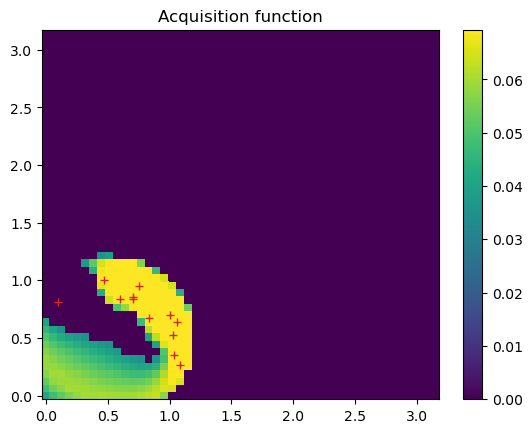

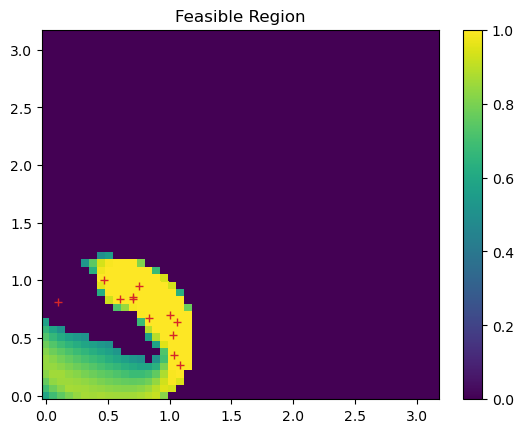

In [8]:
from xopt.generators.bayesian.utils import feasibility

acq_func = generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C3")

    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, generator.sampler, vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    ax2.plot(*data[["x1", "x2"]].to_numpy().T, "+C3")

    fig2.colorbar(c)
    ax2.set_title("Feasible Region")

In [9]:
feasible = X.vocs.feasibility_data(X.data)

In [10]:
feasible['feasible'].value_counts()[False]

1

In [11]:
def custom_priors(c1 = None, c2 = None):
    vocs = deepcopy(tnk_vocs)

    # can only explore one objective
    del vocs.objectives["y2"]
    
    model_options = ModelOptions(mean_modules={"c1":c1, "c2":c2})
    generator_options = BayesianOptions(model=model_options)
    generator = ExpectedImprovementGenerator(vocs, options=generator_options)

    evaluator = Evaluator(function=evaluate_TNK)
    
    X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
    X.evaluate_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.7, 0.95]}))
    
    for i in range(10):
#         print(f"step {i}")
        X.step()
    
    feasible_df = X.vocs.feasibility_data(X.data)
    false_count = (~feasible_df.feasible).sum()
#     print(f'num infeasible: {false_count}')
    return false_count

c1: -20
c1: -19
c1: -18
c1: -17
c1: -16
c1: -15
c1: -14
c1: -13
c1: -12
c1: -11
c1: -10
c1: -9
c1: -8
c1: -7
c1: -6
c1: -5
c1: -4
c1: -3
c1: -2
c1: -1
c1: 0
c1: 1
c1: 2
c1: 3
c1: 4
c1: 5
c1: 6
c1: 7
c1: 8
c1: 9
c1: 10
c1: 11
c1: 12
c1: 13
c1: 14
c1: 15
c1: 16
c1: 17
c1: 18
c1: 19


Text(0, 0.5, 'number of infeasible queries')

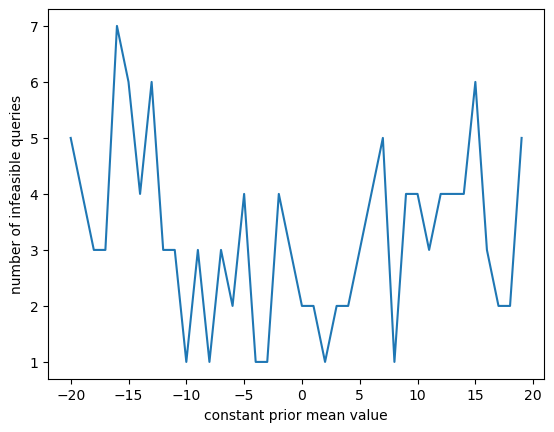

In [12]:
infeasible_count = []
prior = []
for i in range(-20, 20):
    print(f'c1: {i}')
    c2 = ConstantMean()
    c2.initialize(constant=i)
    c2.constant.requires_grad = False
    
    c1 = ConstantMean()
    c1.initialize(constant=i)
    c1.constant.requires_grad = False
    
    false_count = custom_priors(c1, c2)
    prior.append(i)
    infeasible_count.append(false_count)
    
fig, ax = plt.subplots()
ax.plot(prior, infeasible_count)
ax.set_xlabel('constant prior mean value')
ax.set_ylabel('number of infeasible queries')